# Гибридная система идентификации автомобилей

В данном блокноте рассматривается система идентификации автомобилей, в которой система фотофиксации дополнена системой радиочастотной идентификации

In [1]:
import copy
import json
import os

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from pysim.experiments.utility.graphs_style import (
    get_color, setup_matplotlib, savefig
)

from pysim.models.hybrid.cli import check_vars_for_multiprocessing, run_multiple_simulation
from pysim.models.hybrid.objects import Params
from pysim.models.hybrid.processing import result_processing

In [2]:
MAX_ERROR_CAM_PROB = 1
MIN_ERROR_CAM_PROB = 0

MAX_ERROR_RFID_PROB = 1
MIN_ERROR_RFID_PROB = 0

In [3]:
JSON_DIRECTORY = "../results/result_jsons/hybrid/"
os.makedirs(JSON_DIRECTORY, exist_ok=True)

In [4]:
def plate_to_symbol_error(prob: float, symbols_in_plate: int) -> float:
    """
    Преобразование вероятности ошибки идентификации номера в 
    вероятность ошибки идентификации одного символа в номере.
    """
    return 1 - (1 - prob) ** (
            1 / symbols_in_plate
    )

## Зависимость вероятности идентификации автомобиля от **вероятности идентификации RFID системой**

### Подготовка входных данных в модель

In [5]:
save_path = os.path.join(JSON_DIRECTORY, "rfid_probs.json")

params_scheme = Params()
params_dict = params_scheme.model_dump()
rfid_probs = np.linspace(MIN_ERROR_RFID_PROB, MAX_ERROR_RFID_PROB, 25).tolist()
variadic = "rfid_error"
params_dict[variadic] = rfid_probs

# Для каждой кривой своё значение вероятности идентификации камерой
number_photo_err = np.linspace(MIN_ERROR_CAM_PROB, MAX_ERROR_CAM_PROB, 5)
photo_err_probs_list = [
    plate_to_symbol_error(p, params_scheme.number_plate_symbols_amount)
    for p in number_photo_err
]
params_list: list[dict] = []
for photo_err in photo_err_probs_list:
    params_dict["photo_error"] = photo_err
    params_list.append(copy.deepcopy(params_dict))


### Запуск симуляции

In [6]:
results_list = []
for params in tqdm(params_list, desc="Запуск симуляций", unit="модель"):
    statistica = run_multiple_simulation(variadic, **params)
    results_list.append(result_processing(params, statistica, variadic, print_res=False))

Запуск симуляций:   0%|          | 0/5 [00:00<?, ?модель/s]

In [7]:
with open(save_path, "w", encoding="utf-8") as f:
    json.dump({
        "Photo_error_for_each_line": photo_err_probs_list,
        "Params_one_line": params_list,
        "Results_list": [
            [res.model_dump() for res in result_sublist]
            for result_sublist in results_list
        ]
    }, f, ensure_ascii=False, indent=2)

In [8]:
res_probs = []
for line in results_list:
    line_probs = []
    for res in line:
        line_probs.append(res.total_prob)
    res_probs.append(line_probs)

### Построение графиков

In [9]:
setup_matplotlib()
DIRECTORY = "Hybrid"

In [10]:
def invert_probs(probs:list) -> list:
    return [1 - p for p in probs]

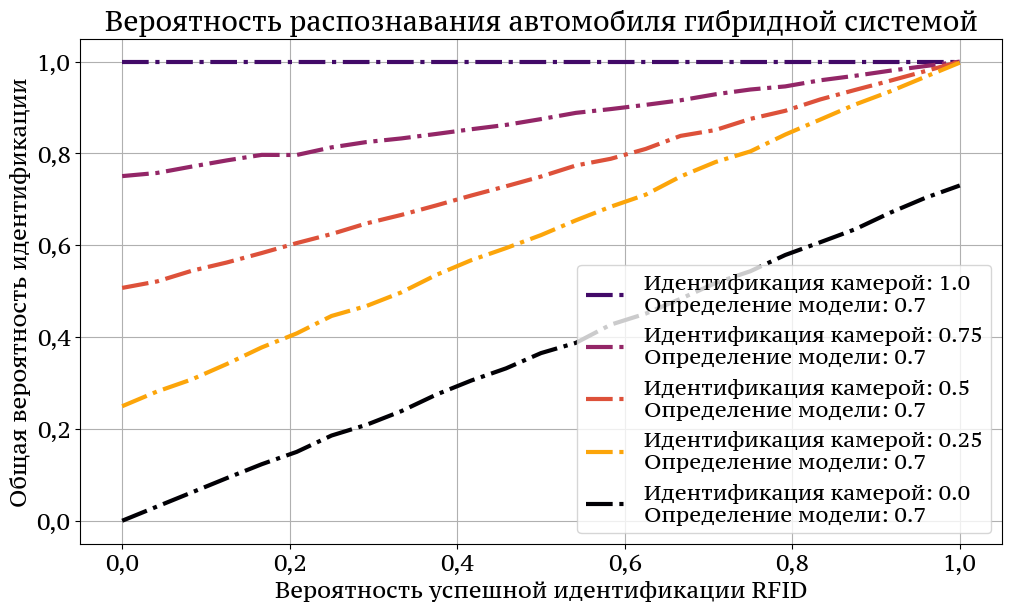

In [11]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")

ax.plot(
    rfid_probs, res_probs[0][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация камерой: {1-number_photo_err[0]}\nОпределение модели: {1-params_dict['car_error']}",
    color=get_color(0.2)
)

ax.plot(
    rfid_probs, res_probs[1][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация камерой: {1-number_photo_err[1]}\nОпределение модели: {1-params_dict['car_error']}",
    color=get_color(0.4)
)

ax.plot(
    rfid_probs, res_probs[2][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация камерой: {1-number_photo_err[2]}\nОпределение модели: {1-params_dict['car_error']}",
    color=get_color(0.6)
)

ax.plot(
    rfid_probs, res_probs[3][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация камерой: {1-number_photo_err[3]}\nОпределение модели: {1-params_dict['car_error']}",
    color=get_color(0.8)
)

ax.plot(
    rfid_probs, res_probs[4][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация камерой: {1-number_photo_err[4]}\nОпределение модели: {1-params_dict['car_error']}",
    color=get_color(1)
)
ax.set_xlabel("Вероятность успешной идентификации RFID")
ax.set_ylabel("Общая вероятность идентификации")
plt.tick_params(axis="both", which="major")
plt.title("Вероятность распознавания автомобиля гибридной системой")
plt.legend(prop={"size":15})
plt.grid()

# savefig(name=f"", directory=DIRECTORY)

## Зависимость вероятности идентификации автомобиля от **вероятности фотофиксации**
Семейство кривых для разных вероятностей RFID

In [12]:
save_path = os.path.join(JSON_DIRECTORY, "photo_probs.json")

params_scheme = Params()
params_dict = params_scheme.model_dump()
photo_probs = np.linspace(MIN_ERROR_CAM_PROB, MAX_ERROR_CAM_PROB, 25).tolist()
photo_err_probs_list = [
    plate_to_symbol_error(p, params_scheme.number_plate_symbols_amount)
    for p in photo_probs
]
variadic = "photo_error"
params_dict[variadic] = photo_err_probs_list

# Для каждой кривой своё значение вероятности идентификации RFID системой
rfid_err_probs_list = np.linspace(MIN_ERROR_RFID_PROB, MAX_ERROR_RFID_PROB, 5)

params_list: list[dict] = []
for rfid_err in rfid_err_probs_list:
    params_dict["rfid_error"] = rfid_err
    params_list.append(copy.deepcopy(params_dict))

### Запуск симуляции

In [13]:
results_list = []
for params in tqdm(params_list, desc="Запуск симуляций", unit="модель"):
    statistica = run_multiple_simulation(variadic, **params)
    results_list.append(result_processing(params, statistica, variadic, print_res=False))

Запуск симуляций:   0%|          | 0/5 [00:00<?, ?модель/s]

In [14]:
res_probs = []
for line in results_list:
    line_probs = []
    for res in line:
        line_probs.append(res.total_prob)
    res_probs.append(line_probs)

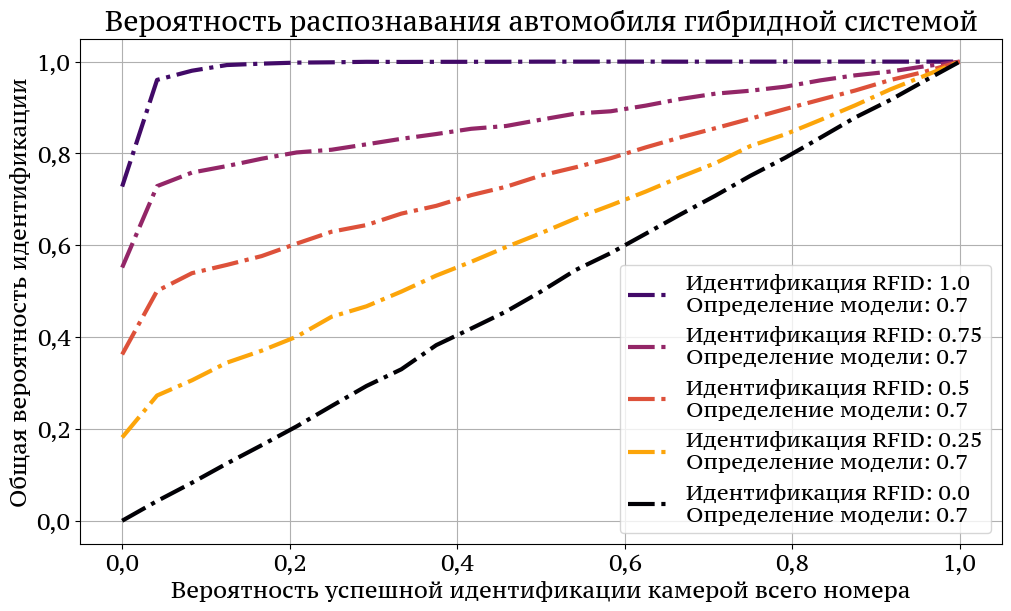

In [15]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")

ax.plot(
    photo_probs, res_probs[0][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация RFID: {1-rfid_err_probs_list[0]}\nОпределение модели: {1-params_dict['car_error']}",
    color=get_color(0.2)
)

ax.plot(
    photo_probs, res_probs[1][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация RFID: {1-rfid_err_probs_list[1]}\nОпределение модели: {1-params_dict['car_error']}",
    color=get_color(0.4)
)

ax.plot(
    photo_probs, res_probs[2][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация RFID: {1-rfid_err_probs_list[2]}\nОпределение модели: {1-params_dict['car_error']}",
    color=get_color(0.6)
)

ax.plot(
    photo_probs, res_probs[3][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация RFID: {1-rfid_err_probs_list[3]}\nОпределение модели: {1-params_dict['car_error']}",
    color=get_color(0.8)
)

ax.plot(
    photo_probs, res_probs[4][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация RFID: {1-rfid_err_probs_list[4]}\nОпределение модели: {1-params_dict['car_error']}",
    color=get_color(1)
)
ax.set_xlabel("Вероятность успешной идентификации камерой всего номера")
ax.set_ylabel("Общая вероятность идентификации")
plt.tick_params(axis="both", which="major")
plt.title("Вероятность распознавания автомобиля гибридной системой")
plt.legend(prop={"size":15})
plt.grid()

# savefig(name=f"", directory=DIRECTORY)

## Зависимость вероятности идентификации автомобиля от **вероятности определения модели**
Семейство кривых для разных вероятностей RFID и фотофиксации

In [73]:
save_path = os.path.join(JSON_DIRECTORY, "model_probs.json")

params_scheme = Params()
params_dict = params_scheme.model_dump()
model_probs = np.linspace(MIN_ERROR_RFID_PROB, MAX_ERROR_RFID_PROB, 25).tolist()
variadic = "car_error"
params_dict[variadic] = model_probs

# Для каждой кривой своё значение вероятности идентификации камерой
number_photo_err = np.linspace(MIN_ERROR_CAM_PROB, MAX_ERROR_CAM_PROB, 5)
photo_err_probs_list = [
    plate_to_symbol_error(p, params_scheme.number_plate_symbols_amount)
    for p in number_photo_err
]
params_list: list[dict] = []
for photo_err in photo_err_probs_list:
    params_dict["photo_error"] = photo_err
    params_list.append(copy.deepcopy(params_dict))

In [74]:
results_list = []
for params in tqdm(params_list, desc="Запуск симуляций", unit="модель"):
    statistica = run_multiple_simulation(variadic, **params)
    results_list.append(result_processing(params, statistica, variadic, print_res=False))

Запуск симуляций:   0%|          | 0/5 [00:00<?, ?модель/s]

In [75]:
res_probs = []
for line in results_list:
    line_probs = []
    for res in line:
        line_probs.append(res.total_prob)
    res_probs.append(line_probs)

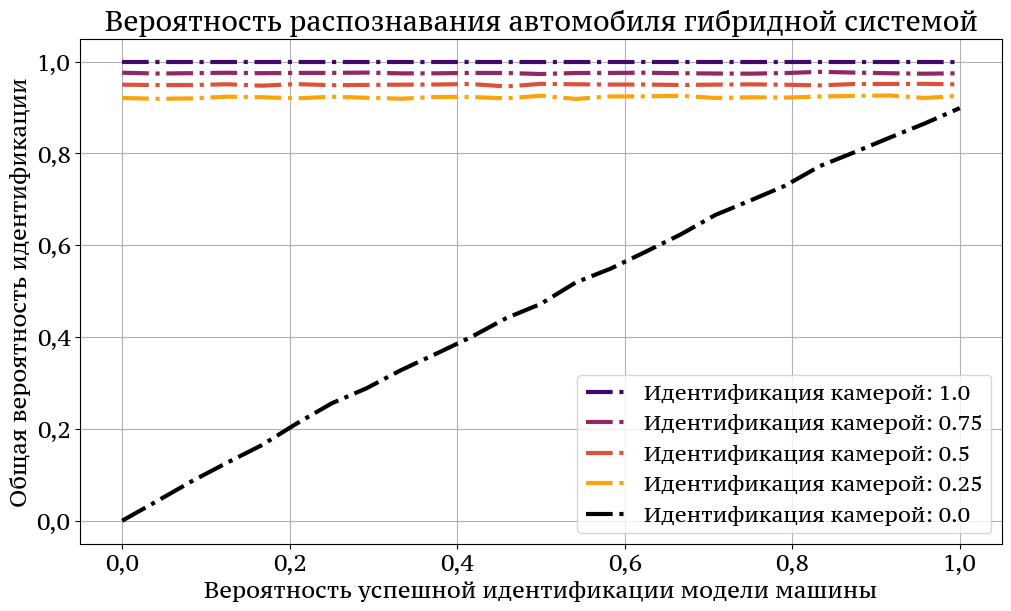

In [78]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")

ax.plot(
    model_probs, res_probs[0][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация камерой: {1-number_photo_err[0]}",
    color=get_color(0.2)
)

ax.plot(
    model_probs, res_probs[1][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация камерой: {1-number_photo_err[1]}",
    color=get_color(0.4)
)

ax.plot(
    model_probs, res_probs[2][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация камерой: {1-number_photo_err[2]}",
    color=get_color(0.6)
)

ax.plot(
    model_probs, res_probs[3][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация камерой: {1-number_photo_err[3]}",
    color=get_color(0.8)
)

ax.plot(
    model_probs, res_probs[4][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Идентификация камерой: {1-number_photo_err[4]}",
    color=get_color(1)
)
ax.set_xlabel("Вероятность успешной идентификации модели машины")
ax.set_ylabel("Общая вероятность идентификации")
plt.tick_params(axis="both", which="major")
plt.title("Вероятность распознавания автомобиля гибридной системой")
plt.legend(prop={"size":15})
plt.grid()

# savefig(name=f"", directory=DIRECTORY)

## Зависимость доли коллизий от **вероятности фотофиксации**
Семейство кривых для разных вероятностей RFID

In [5]:
params_scheme = Params()
params_dict = params_scheme.model_dump()
photo_probs = np.linspace(MIN_ERROR_CAM_PROB, MAX_ERROR_CAM_PROB, 25).tolist()
photo_err_probs_list = [
    plate_to_symbol_error(p, params_scheme.number_plate_symbols_amount)
    for p in photo_probs
]
variadic = "photo_error"
params_dict[variadic] = photo_err_probs_list

# Для каждой кривой своё значение вероятности идентификации RFID системой
rfid_err_probs_list = [MIN_ERROR_RFID_PROB]

params_list: list[dict] = []
for rfid_err in rfid_err_probs_list:
    params_dict["rfid_error"] = rfid_err
    params_list.append(copy.deepcopy(params_dict))

In [6]:
results_list = []
statistica = run_multiple_simulation(variadic, **params_list[0])
results_list.append(result_processing(params_list[0], statistica, variadic, print_res=False))

Process SpawnPoolWorker-4:
Process SpawnPoolWorker-9:
Process SpawnPoolWorker-3:
Process SpawnPoolWorker-5:
Process SpawnPoolWorker-10:
Process SpawnPoolWorker-8:
Process SpawnPoolWorker-11:
Process SpawnPoolWorker-6:
Process SpawnPoolWorker-2:
Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
           ^^^^^^^^^^^^^^^^
  File "

KeyboardInterrupt: 

In [7]:
res_collisions = []
for line in results_list:
    line_collisions = []
    for res in line:
        line_collisions.append(res.total_collisions/params_scheme.num_plates)
    res_collisions.append(line_collisions)

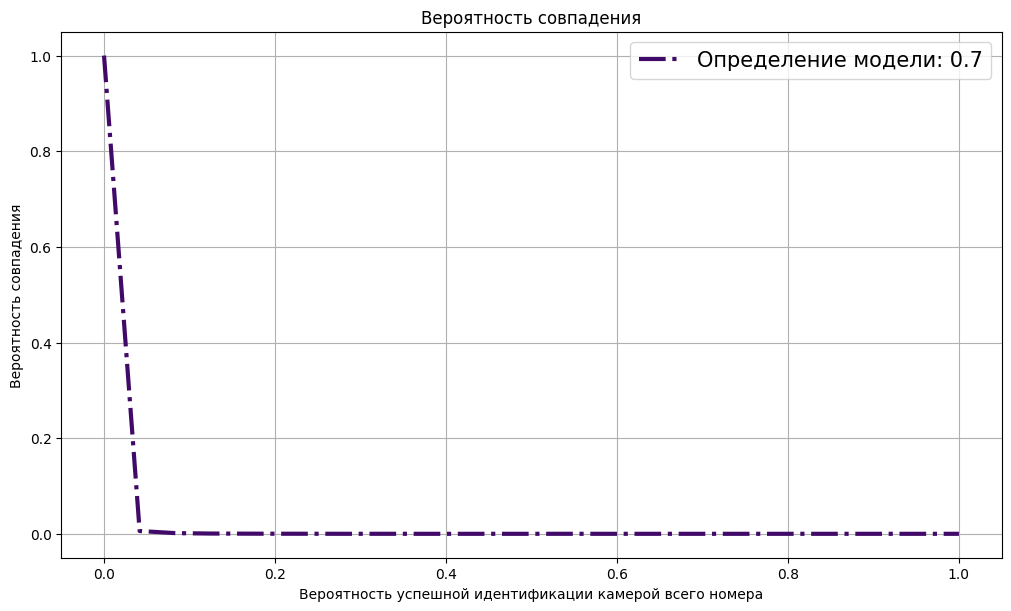

In [8]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")

ax.plot(
    photo_probs, res_collisions[0][::-1],
    linewidth=3, linestyle="dashdot",
    label=f"Определение модели: {1-params_dict['car_error']}",
    color=get_color(0.2)
)


ax.set_xlabel("Вероятность успешной идентификации камерой всего номера")
ax.set_ylabel("Вероятность совпадения")
plt.tick_params(axis="both", which="major")
plt.title("Вероятность совпадения")
plt.legend(prop={"size":15})
plt.grid()

## Количество неразрешённых коллизий при больших вероятностях ошибки идентификации камерой

In [14]:
save_path = os.path.join(JSON_DIRECTORY, "big_photo_probs.json")

params_scheme = Params()
params_dict = params_scheme.model_dump()
photo_probs = np.linspace(0.97, 1, 25).tolist()
photo_err_probs_list = [
    plate_to_symbol_error(p, params_scheme.number_plate_symbols_amount)
    for p in photo_probs
]
variadic = "photo_error"
params_dict[variadic] = photo_err_probs_list

params_dict["rfid_error"] = 0

# Для каждой кривой своё значение вероятности идентификации модели машины
model_err_probs_list = np.linspace(0, 1, 5)

params_list: list[dict] = []
for model_err in model_err_probs_list:
    params_dict["car_error"] = model_err
    params_list.append(copy.deepcopy(params_dict))

In [15]:
results_list = []
for params in tqdm(params_list, desc="Запуск симуляций", unit="модель"):
    statistica = run_multiple_simulation(variadic, **params)
    results_list.append(result_processing(params, statistica, variadic, print_res=False))

Запуск симуляций:   0%|          | 0/5 [00:00<?, ?модель/s]

In [16]:
res_probs = []
for line in results_list:
    line_probs = []
    for res in line:
        line_probs.append(res.unresolved_collision_amount)
    res_probs.append(line_probs)

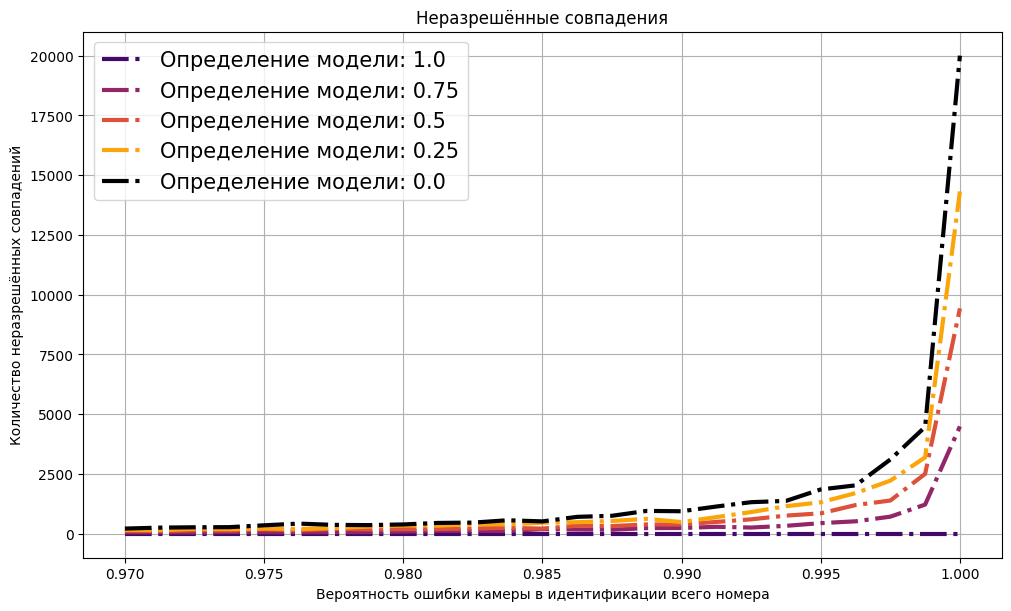

In [17]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")

ax.plot(
    photo_probs, res_probs[0],
    linewidth=3, linestyle="dashdot",
    label=f"Определение модели: {1-model_err_probs_list[0]}",
    color=get_color(0.2)
)

ax.plot(
    photo_probs, res_probs[1],
    linewidth=3, linestyle="dashdot",
    label=f"Определение модели: {1-model_err_probs_list[1]}",
    color=get_color(0.4)
)

ax.plot(
    photo_probs, res_probs[2],
    linewidth=3, linestyle="dashdot",
    label=f"Определение модели: {1-model_err_probs_list[2]}",
    color=get_color(0.6)
)

ax.plot(
    photo_probs, res_probs[3],
    linewidth=3, linestyle="dashdot",
    label=f"Определение модели: {1-model_err_probs_list[3]}",
    color=get_color(0.8)
)

ax.plot(
    photo_probs, res_probs[4],
    linewidth=3, linestyle="dashdot",
    label=f"Определение модели: {1-model_err_probs_list[4]}",
    color=get_color(1)
)
ax.set_xlabel("Вероятность ошибки камеры в идентификации всего номера")
ax.set_ylabel("Количество неразрешённых совпадений")
plt.tick_params(axis="both", which="major")
plt.title("Неразрешённые совпадения")
plt.legend(prop={"size":15})
plt.grid()

# savefig(name=f"", directory=DIRECTORY)

## Количество неправильно разрешённых коллизий при больших вероятностях ошибки идентификации камерой

In [18]:
res_probs = []
for line in results_list:
    line_probs = []
    for res in line:
        line_probs.append(res.error_collision_resolve_amount)
    res_probs.append(line_probs)

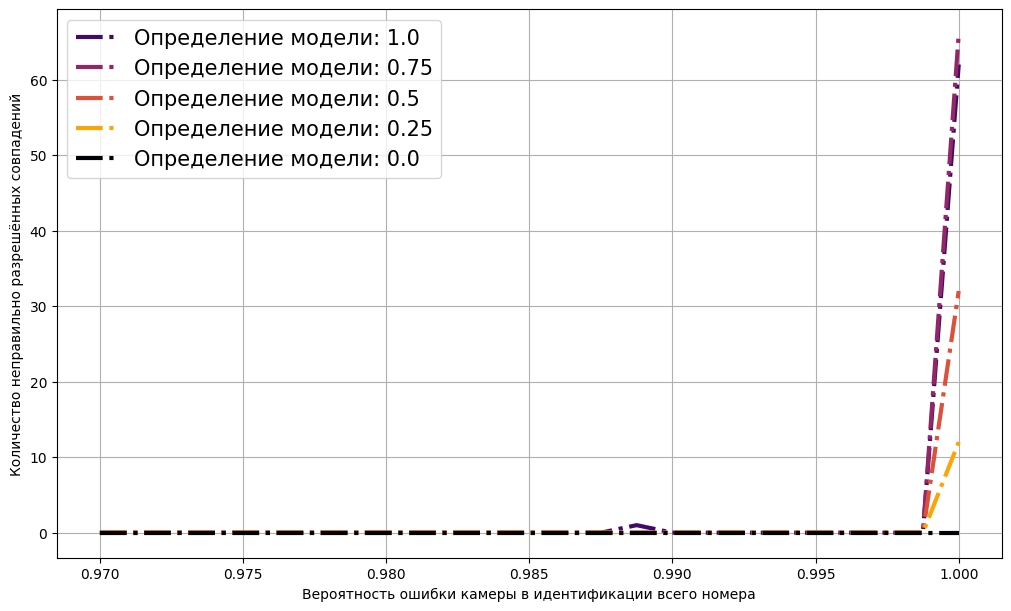

In [22]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")

ax.plot(
    photo_probs, res_probs[0],
    linewidth=3, linestyle="dashdot",
    label=f"Определение модели: {1-model_err_probs_list[0]}",
    color=get_color(0.2)
)

ax.plot(
    photo_probs, res_probs[1],
    linewidth=3, linestyle="dashdot",
    label=f"Определение модели: {1-model_err_probs_list[1]}",
    color=get_color(0.4)
)

ax.plot(
    photo_probs, res_probs[2],
    linewidth=3, linestyle="dashdot",
    label=f"Определение модели: {1-model_err_probs_list[2]}",
    color=get_color(0.6)
)

ax.plot(
    photo_probs, res_probs[3],
    linewidth=3, linestyle="dashdot",
    label=f"Определение модели: {1-model_err_probs_list[3]}",
    color=get_color(0.8)
)

ax.plot(
    photo_probs, res_probs[4],
    linewidth=3, linestyle="dashdot",
    label=f"Определение модели: {1-model_err_probs_list[4]}",
    color=get_color(1)
)
ax.set_xlabel("Вероятность ошибки камеры в идентификации всего номера")
ax.set_ylabel("Количество неправильно разрешённых совпадений")
plt.tick_params(axis="both", which="major")
plt.title("")
plt.legend(prop={"size":15})
plt.grid()

# savefig(name=f"", directory=DIRECTORY)